# 라이브러리 import

In [10]:
import os
import tqdm
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

## gpu확인
- tensorflowjs를 설치하면서 다음과 같이 추가로 설치되는 것들이 있다.
    ![Screenshot from 2020-09-15 20-04-41](https://user-images.githubusercontent.com/48716219/93205392-b5774580-f792-11ea-8518-3dc18690e18c.png)
    - 오전에 잠깐 이것때문인지는 몰라도 노트북이 커널에 연결이 되지 않는 현상 발생
    - ```tensorflow-cpu```, ```tensorflowjs```삭제 후 ```tensorflow-gpu==2.2.0``` 다시 재설치해서 복구

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 데이터 전처리 및 나누기
- 캐글에 있는 open Dataset 사용
    - [Facial Expression](https://www.kaggle.com/ahmedmoorsy/facial-expression)
- 정규화 및 ```train```, ```validation``` 데이터셋 구성

In [5]:
train_x = []
train_y = []
eval_x = []
eval_y = []

csv_path = os.getenv('HOME')+'/aiffel/tfjs_mobile/data/fer2013.csv'

with open(csv_path) as f:
    for line in tqdm.tqdm(f.read().splitlines()[1:]):
        emotion, pixels, usage = line.split(',')
    
        x = np.array(pixels.split(' ')).astype(float).reshape(48, 48, 1) / 255
        y = int(emotion)

    if usage == 'PrivateTest':
        eval_x.append(x)
        eval_y.append(y)
    else:
        train_x.append(x)
        train_y.append(y)

print('train : {}, eval :{}'.format(len(train_x), len(eval_x)))

100%|██████████| 35887/35887 [00:24<00:00, 1473.88it/s]

train : 32298, eval :3589


## 데이터 확인

Angry


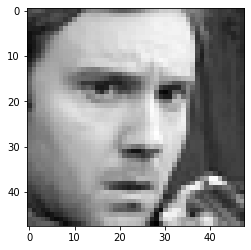

In [6]:
LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

print(LABELS[train_y[0]])
plt.imshow(train_x[0].reshape([48, 48]), cmap='gray')

# 학습
- MobileNetV2 사용
    - Adam(lr=0.001), CategoricalCrossentropy, CategoricalAccuracy
- ModelCheckpoint 사용
    - 평가기준 47점을 넘기기위해서 가장 높은 점수를 기록할 때마다 모델을 저장시키도록 하였다.

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint
mc = ModelCheckpoint('best.h5', monitor='val_categorical_accuracy', verbose=1, mode='auto', save_best_only=True)

In [11]:
# model 선언 
model = tf.keras.applications.MobileNetV2(input_shape=(48, 48, 1), weights=None, classes=7)

# model.compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()])

#model.fit
hist = model.fit(np.stack(train_x),
          tf.keras.utils.to_categorical(train_y),
          epochs=500,
          batch_size=512,
          validation_data=(np.stack(eval_x),
                           tf.keras.utils.to_categorical(eval_y)),
         callbacks=[mc])

Epoch 1/500
63/64 [============================>.] - ETA: 0s - loss: 1.8308 - categorical_accuracy: 0.2526
Epoch 00001: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 7s 103ms/step - loss: 1.8307 - categorical_accuracy: 0.2528 - val_loss: 1.9297 - val_categorical_accuracy: 0.1655
Epoch 2/500
63/64 [============================>.] - ETA: 0s - loss: 1.6534 - categorical_accuracy: 0.3429
Epoch 00002: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 1.6532 - categorical_accuracy: 0.3430 - val_loss: 1.9158 - val_categorical_accuracy: 0.1655
Epoch 3/500
63/64 [============================>.] - ETA: 0s - loss: 1.5320 - categorical_accuracy: 0.4032
Epoch 00003: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 96ms/step - loss: 1.5321 - categorical_accuracy: 0.4032 - val_loss: 1.9085 - val_categorical_accuracy: 0.1655
Epoch 4/500
63/

Epoch 26/500
63/64 [============================>.] - ETA: 0s - loss: 0.3515 - categorical_accuracy: 0.8752
Epoch 00026: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 96ms/step - loss: 0.3515 - categorical_accuracy: 0.8752 - val_loss: 2.3127 - val_categorical_accuracy: 0.1655
Epoch 27/500
63/64 [============================>.] - ETA: 0s - loss: 0.3149 - categorical_accuracy: 0.8887
Epoch 00027: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 97ms/step - loss: 0.3152 - categorical_accuracy: 0.8887 - val_loss: 2.3632 - val_categorical_accuracy: 0.1655
Epoch 28/500
63/64 [============================>.] - ETA: 0s - loss: 0.3364 - categorical_accuracy: 0.8808
Epoch 00028: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 97ms/step - loss: 0.3366 - categorical_accuracy: 0.8807 - val_loss: 2.4090 - val_categorical_accuracy: 0.1655
Epoch 29/500


Epoch 51/500
63/64 [============================>.] - ETA: 0s - loss: 0.1300 - categorical_accuracy: 0.9561
Epoch 00051: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 99ms/step - loss: 0.1302 - categorical_accuracy: 0.9560 - val_loss: 2.7836 - val_categorical_accuracy: 0.1655
Epoch 52/500
63/64 [============================>.] - ETA: 0s - loss: 0.1854 - categorical_accuracy: 0.9359
Epoch 00052: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 97ms/step - loss: 0.1854 - categorical_accuracy: 0.9359 - val_loss: 2.6302 - val_categorical_accuracy: 0.1655
Epoch 53/500
63/64 [============================>.] - ETA: 0s - loss: 0.1457 - categorical_accuracy: 0.9500
Epoch 00053: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 97ms/step - loss: 0.1458 - categorical_accuracy: 0.9499 - val_loss: 2.6299 - val_categorical_accuracy: 0.1655
Epoch 54/500


Epoch 76/500
63/64 [============================>.] - ETA: 0s - loss: 0.1604 - categorical_accuracy: 0.9453
Epoch 00076: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 98ms/step - loss: 0.1609 - categorical_accuracy: 0.9452 - val_loss: 3.2032 - val_categorical_accuracy: 0.3196
Epoch 77/500
63/64 [============================>.] - ETA: 0s - loss: 0.1584 - categorical_accuracy: 0.9461
Epoch 00077: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 97ms/step - loss: 0.1586 - categorical_accuracy: 0.9461 - val_loss: 3.3309 - val_categorical_accuracy: 0.3369
Epoch 78/500
63/64 [============================>.] - ETA: 0s - loss: 0.1148 - categorical_accuracy: 0.9603
Epoch 00078: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.1147 - categorical_accuracy: 0.9603 - val_loss: 3.3169 - val_categorical_accuracy: 0.3475
Epoch 79/500


Epoch 101/500
63/64 [============================>.] - ETA: 0s - loss: 0.0875 - categorical_accuracy: 0.9700
Epoch 00101: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0876 - categorical_accuracy: 0.9699 - val_loss: 5.6966 - val_categorical_accuracy: 0.3979
Epoch 102/500
63/64 [============================>.] - ETA: 0s - loss: 0.1083 - categorical_accuracy: 0.9641
Epoch 00102: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.1088 - categorical_accuracy: 0.9639 - val_loss: 5.5400 - val_categorical_accuracy: 0.4051
Epoch 103/500
63/64 [============================>.] - ETA: 0s - loss: 0.1599 - categorical_accuracy: 0.9443
Epoch 00103: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 97ms/step - loss: 0.1600 - categorical_accuracy: 0.9443 - val_loss: 5.6978 - val_categorical_accuracy: 0.4230
Epoch 104/

Epoch 126/500
63/64 [============================>.] - ETA: 0s - loss: 0.1633 - categorical_accuracy: 0.9435
Epoch 00126: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.1634 - categorical_accuracy: 0.9435 - val_loss: 6.5928 - val_categorical_accuracy: 0.4288
Epoch 127/500
63/64 [============================>.] - ETA: 0s - loss: 0.0794 - categorical_accuracy: 0.9728
Epoch 00127: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0793 - categorical_accuracy: 0.9728 - val_loss: 6.4096 - val_categorical_accuracy: 0.4076
Epoch 128/500
63/64 [============================>.] - ETA: 0s - loss: 0.0390 - categorical_accuracy: 0.9863
Epoch 00128: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0390 - categorical_accuracy: 0.9863 - val_loss: 6.7148 - val_categorical_accuracy: 0.3990
Epoch 129/

Epoch 151/500
63/64 [============================>.] - ETA: 0s - loss: 0.1220 - categorical_accuracy: 0.9577
Epoch 00151: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.1221 - categorical_accuracy: 0.9577 - val_loss: 6.0637 - val_categorical_accuracy: 0.4079
Epoch 152/500
63/64 [============================>.] - ETA: 0s - loss: 0.0935 - categorical_accuracy: 0.9670
Epoch 00152: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0933 - categorical_accuracy: 0.9671 - val_loss: 6.3324 - val_categorical_accuracy: 0.4082
Epoch 153/500
63/64 [============================>.] - ETA: 0s - loss: 0.0351 - categorical_accuracy: 0.9873
Epoch 00153: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0351 - categorical_accuracy: 0.9873 - val_loss: 6.2555 - val_categorical_accuracy: 0.4090
Epoch 154/

Epoch 176/500
63/64 [============================>.] - ETA: 0s - loss: 0.0670 - categorical_accuracy: 0.9768
Epoch 00176: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0671 - categorical_accuracy: 0.9767 - val_loss: 5.9080 - val_categorical_accuracy: 0.4040
Epoch 177/500
63/64 [============================>.] - ETA: 0s - loss: 0.0693 - categorical_accuracy: 0.9756
Epoch 00177: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0697 - categorical_accuracy: 0.9756 - val_loss: 5.7037 - val_categorical_accuracy: 0.4135
Epoch 178/500
63/64 [============================>.] - ETA: 0s - loss: 0.1155 - categorical_accuracy: 0.9599
Epoch 00178: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.1154 - categorical_accuracy: 0.9599 - val_loss: 6.2066 - val_categorical_accuracy: 0.4043
Epoch 179/

Epoch 201/500
63/64 [============================>.] - ETA: 0s - loss: 0.0515 - categorical_accuracy: 0.9825
Epoch 00201: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0515 - categorical_accuracy: 0.9825 - val_loss: 5.1483 - val_categorical_accuracy: 0.4299
Epoch 202/500
63/64 [============================>.] - ETA: 0s - loss: 0.0461 - categorical_accuracy: 0.9842
Epoch 00202: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0462 - categorical_accuracy: 0.9841 - val_loss: 4.7990 - val_categorical_accuracy: 0.4366
Epoch 203/500
63/64 [============================>.] - ETA: 0s - loss: 0.0732 - categorical_accuracy: 0.9749
Epoch 00203: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0732 - categorical_accuracy: 0.9750 - val_loss: 5.4267 - val_categorical_accuracy: 0.4425
Epoch 204/

Epoch 226/500
63/64 [============================>.] - ETA: 0s - loss: 0.0262 - categorical_accuracy: 0.9902
Epoch 00226: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0263 - categorical_accuracy: 0.9902 - val_loss: 4.9708 - val_categorical_accuracy: 0.4564
Epoch 227/500
63/64 [============================>.] - ETA: 0s - loss: 0.0707 - categorical_accuracy: 0.9752
Epoch 00227: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0708 - categorical_accuracy: 0.9752 - val_loss: 5.1300 - val_categorical_accuracy: 0.4544
Epoch 228/500
63/64 [============================>.] - ETA: 0s - loss: 0.0658 - categorical_accuracy: 0.9760
Epoch 00228: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 96ms/step - loss: 0.0657 - categorical_accuracy: 0.9760 - val_loss: 5.2040 - val_categorical_accuracy: 0.4455
Epoch 229/

Epoch 251/500
63/64 [============================>.] - ETA: 0s - loss: 0.0290 - categorical_accuracy: 0.9894
Epoch 00251: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0290 - categorical_accuracy: 0.9894 - val_loss: 5.0747 - val_categorical_accuracy: 0.4472
Epoch 252/500
63/64 [============================>.] - ETA: 0s - loss: 0.0194 - categorical_accuracy: 0.9922
Epoch 00252: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0194 - categorical_accuracy: 0.9923 - val_loss: 5.5137 - val_categorical_accuracy: 0.4620
Epoch 253/500
63/64 [============================>.] - ETA: 0s - loss: 0.0174 - categorical_accuracy: 0.9931
Epoch 00253: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0179 - categorical_accuracy: 0.9930 - val_loss: 5.1878 - val_categorical_accuracy: 0.4531
Epoch 254/

Epoch 276/500
63/64 [============================>.] - ETA: 0s - loss: 0.0382 - categorical_accuracy: 0.9869
Epoch 00276: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0382 - categorical_accuracy: 0.9869 - val_loss: 4.8858 - val_categorical_accuracy: 0.4517
Epoch 277/500
63/64 [============================>.] - ETA: 0s - loss: 0.0524 - categorical_accuracy: 0.9814
Epoch 00277: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 96ms/step - loss: 0.0525 - categorical_accuracy: 0.9813 - val_loss: 4.9327 - val_categorical_accuracy: 0.4517
Epoch 278/500
63/64 [============================>.] - ETA: 0s - loss: 0.0480 - categorical_accuracy: 0.9831
Epoch 00278: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0481 - categorical_accuracy: 0.9830 - val_loss: 5.0427 - val_categorical_accuracy: 0.4458
Epoch 279/

Epoch 301/500
63/64 [============================>.] - ETA: 0s - loss: 0.0904 - categorical_accuracy: 0.9685
Epoch 00301: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0907 - categorical_accuracy: 0.9685 - val_loss: 4.9883 - val_categorical_accuracy: 0.4497
Epoch 302/500
63/64 [============================>.] - ETA: 0s - loss: 0.0556 - categorical_accuracy: 0.9803
Epoch 00302: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0555 - categorical_accuracy: 0.9803 - val_loss: 5.1090 - val_categorical_accuracy: 0.4475
Epoch 303/500
63/64 [============================>.] - ETA: 0s - loss: 0.0226 - categorical_accuracy: 0.9920
Epoch 00303: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0227 - categorical_accuracy: 0.9919 - val_loss: 4.9299 - val_categorical_accuracy: 0.4692
Epoch 304/

Epoch 326/500
63/64 [============================>.] - ETA: 0s - loss: 0.0300 - categorical_accuracy: 0.9902
Epoch 00326: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0300 - categorical_accuracy: 0.9902 - val_loss: 4.7296 - val_categorical_accuracy: 0.4620
Epoch 327/500
63/64 [============================>.] - ETA: 0s - loss: 0.0335 - categorical_accuracy: 0.9876
Epoch 00327: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 99ms/step - loss: 0.0336 - categorical_accuracy: 0.9875 - val_loss: 4.5784 - val_categorical_accuracy: 0.4661
Epoch 328/500
63/64 [============================>.] - ETA: 0s - loss: 0.0934 - categorical_accuracy: 0.9690
Epoch 00328: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0935 - categorical_accuracy: 0.9689 - val_loss: 5.0561 - val_categorical_accuracy: 0.4464
Epoch 329/

Epoch 351/500
63/64 [============================>.] - ETA: 0s - loss: 0.0340 - categorical_accuracy: 0.9882
Epoch 00351: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0341 - categorical_accuracy: 0.9881 - val_loss: 4.5975 - val_categorical_accuracy: 0.4695
Epoch 352/500
63/64 [============================>.] - ETA: 0s - loss: 0.0564 - categorical_accuracy: 0.9802
Epoch 00352: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 95ms/step - loss: 0.0565 - categorical_accuracy: 0.9802 - val_loss: 4.4512 - val_categorical_accuracy: 0.4700
Epoch 353/500
63/64 [============================>.] - ETA: 0s - loss: 0.0362 - categorical_accuracy: 0.9873
Epoch 00353: val_categorical_accuracy did not improve from 0.49150
64/64 [==============================] - 6s 94ms/step - loss: 0.0363 - categorical_accuracy: 0.9872 - val_loss: 4.6013 - val_categorical_accuracy: 0.4767
Epoch 354/

Epoch 376/500
63/64 [============================>.] - ETA: 0s - loss: 0.0071 - categorical_accuracy: 0.9971
Epoch 00376: val_categorical_accuracy did not improve from 0.49401
64/64 [==============================] - 6s 94ms/step - loss: 0.0071 - categorical_accuracy: 0.9971 - val_loss: 4.5648 - val_categorical_accuracy: 0.4876
Epoch 377/500
63/64 [============================>.] - ETA: 0s - loss: 0.0047 - categorical_accuracy: 0.9975
Epoch 00377: val_categorical_accuracy did not improve from 0.49401
64/64 [==============================] - 6s 94ms/step - loss: 0.0050 - categorical_accuracy: 0.9975 - val_loss: 4.6281 - val_categorical_accuracy: 0.4848
Epoch 378/500
63/64 [============================>.] - ETA: 0s - loss: 0.0440 - categorical_accuracy: 0.9844
Epoch 00378: val_categorical_accuracy did not improve from 0.49401
64/64 [==============================] - 6s 94ms/step - loss: 0.0443 - categorical_accuracy: 0.9843 - val_loss: 4.5788 - val_categorical_accuracy: 0.4759
Epoch 379/

Epoch 401/500
63/64 [============================>.] - ETA: 0s - loss: 0.0289 - categorical_accuracy: 0.9888
Epoch 00401: val_categorical_accuracy did not improve from 0.49401
64/64 [==============================] - 6s 94ms/step - loss: 0.0289 - categorical_accuracy: 0.9888 - val_loss: 4.8410 - val_categorical_accuracy: 0.4581
Epoch 402/500
63/64 [============================>.] - ETA: 0s - loss: 0.0342 - categorical_accuracy: 0.9878
Epoch 00402: val_categorical_accuracy did not improve from 0.49401
64/64 [==============================] - 6s 94ms/step - loss: 0.0343 - categorical_accuracy: 0.9877 - val_loss: 4.7222 - val_categorical_accuracy: 0.4806
Epoch 403/500
63/64 [============================>.] - ETA: 0s - loss: 0.0578 - categorical_accuracy: 0.9806
Epoch 00403: val_categorical_accuracy did not improve from 0.49401
64/64 [==============================] - 6s 94ms/step - loss: 0.0578 - categorical_accuracy: 0.9806 - val_loss: 4.5202 - val_categorical_accuracy: 0.4664
Epoch 404/

Epoch 426/500
63/64 [============================>.] - ETA: 0s - loss: 0.0487 - categorical_accuracy: 0.9825
Epoch 00426: val_categorical_accuracy did not improve from 0.49763
64/64 [==============================] - 6s 94ms/step - loss: 0.0487 - categorical_accuracy: 0.9826 - val_loss: 4.6667 - val_categorical_accuracy: 0.4519
Epoch 427/500
63/64 [============================>.] - ETA: 0s - loss: 0.0340 - categorical_accuracy: 0.9878
Epoch 00427: val_categorical_accuracy did not improve from 0.49763
64/64 [==============================] - 6s 94ms/step - loss: 0.0340 - categorical_accuracy: 0.9877 - val_loss: 4.5396 - val_categorical_accuracy: 0.4614
Epoch 428/500
63/64 [============================>.] - ETA: 0s - loss: 0.0217 - categorical_accuracy: 0.9921
Epoch 00428: val_categorical_accuracy did not improve from 0.49763
64/64 [==============================] - 6s 94ms/step - loss: 0.0217 - categorical_accuracy: 0.9921 - val_loss: 4.4196 - val_categorical_accuracy: 0.4781
Epoch 429/

Epoch 451/500
63/64 [============================>.] - ETA: 0s - loss: 0.0346 - categorical_accuracy: 0.9872
Epoch 00451: val_categorical_accuracy did not improve from 0.49763
64/64 [==============================] - 6s 94ms/step - loss: 0.0351 - categorical_accuracy: 0.9871 - val_loss: 4.4292 - val_categorical_accuracy: 0.4790
Epoch 452/500
63/64 [============================>.] - ETA: 0s - loss: 0.0731 - categorical_accuracy: 0.9754
Epoch 00452: val_categorical_accuracy did not improve from 0.49763
64/64 [==============================] - 6s 94ms/step - loss: 0.0733 - categorical_accuracy: 0.9753 - val_loss: 4.0992 - val_categorical_accuracy: 0.4636
Epoch 453/500
63/64 [============================>.] - ETA: 0s - loss: 0.0652 - categorical_accuracy: 0.9773
Epoch 00453: val_categorical_accuracy did not improve from 0.49763
64/64 [==============================] - 6s 94ms/step - loss: 0.0652 - categorical_accuracy: 0.9773 - val_loss: 4.2242 - val_categorical_accuracy: 0.4831
Epoch 454/

Epoch 476/500
63/64 [============================>.] - ETA: 0s - loss: 0.0255 - categorical_accuracy: 0.9908
Epoch 00476: val_categorical_accuracy did not improve from 0.50543
64/64 [==============================] - 6s 94ms/step - loss: 0.0255 - categorical_accuracy: 0.9908 - val_loss: 4.5456 - val_categorical_accuracy: 0.4982
Epoch 477/500
63/64 [============================>.] - ETA: 0s - loss: 0.0142 - categorical_accuracy: 0.9945
Epoch 00477: val_categorical_accuracy did not improve from 0.50543
64/64 [==============================] - 6s 95ms/step - loss: 0.0143 - categorical_accuracy: 0.9945 - val_loss: 4.4239 - val_categorical_accuracy: 0.4985
Epoch 478/500
63/64 [============================>.] - ETA: 0s - loss: 0.0168 - categorical_accuracy: 0.9939
Epoch 00478: val_categorical_accuracy did not improve from 0.50543
64/64 [==============================] - 6s 95ms/step - loss: 0.0169 - categorical_accuracy: 0.9938 - val_loss: 4.4890 - val_categorical_accuracy: 0.5015
Epoch 479/

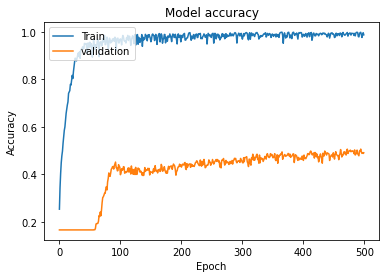

In [16]:
# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다. 
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

#### 노트북 파일 동일 위치에 모델이 저장되어 있는지 확인

In [9]:
import os
os.path.exists('best.h5')

True

# 정리

---

1. 표정 데이터로 ```MobileNet``` 학습 : ```face2emoji.ipynb```
    - 데이터 받기 : [Facial Expression](https://www.kaggle.com/ahmedmoorsy/facial-expression)
    - 정규화하기 + Train, Validation 나누기 (train : 32298, eval :3589)
    - ```MobileNetV2```로 활용
    - ModelCheckpoint사용, val_categorical_accuracy가 가장 좋을 때를 기준으로 모델을 저장
        - 최고 socre : 50.571점
2. 학습된 모델을 TensorFlow.js 형식으로 변환
    - 위에서 저장한 가장 좋은 스코어의 모델로 TensorFlow.js를 활용
        ```shell
$ pip install tensorflowjs
$ cd '모델이 저장되어 있는 경로'
$ tensorflowjs_converter --input_format=keras model.h5 model
        ```
3. 카메라에서 영상 가져오기 : ```index.html```
    - 웹캠에서 영상 가져오기
    - 캡쳐후 버튼 옆에 작게 사진을 표시
4. MobileNet 추론 결과 표시
    - ```<span>``` 태그를 활용, 추론 결과를 표시
    - 7가지 감정 표시
        - 🤬 : angry, 🤢 : disgust, 😱 : fear, 😄 : happy, 😲 : surprise, 😢 : sad, 😐 : neutral
5. github page에 HTML과 MobileNet 모델 배포하기
    - [https://ljh415.github.io/tfjs_mobile](https://ljh415.github.io/tfjs_mobile)

---

## 개선사항
1. 얼굴인식
    - 기존에 사용했던 얼굴인식 방법은 **```dlib```**, **```face_recognition```** 과 같은 라이브러리를 사용했다. 이미지에서부터 **'얼굴'을 찾아서** 랜드마크를 찾아서 스티커 이미지를 붙이거나 임베딩 벡터를 생성해서 닮은 꼴을 찾았다. 여기서 중요한 것은 사진에서부터 **얼굴**을 찾는 것이지만 여기서는 특별히 얼굴을 찾는 부분은 없다. 
    - 실제로 벽을 찍거나 <u>얼굴이 없는 사진</u>으로도 학습시킨 모델을 사용해서 이모지를 결과로 보여주지만 실제로 정답 score자체는 낮게 나올것이다. 하지만 사람의 얼굴을 인식해야 하는 것이기 때문에 위에서 언급한 방법을 사용하는 것이 더 좋을 것이라고 생각한다.

2. 모델 훈련 방식
    - ```weights='None'```으로 사용했지만 Classification을 수행하는 윗부분을 그대로 사용하고 있다.
    - **```include_top=False```**를 사용해서 Feature_extraction하는 모델의 구조만 가져오고 **Classification층을 새로 구성**해보는 것도 괜찮을 것 같다.
    - 하지만 기존의 데이터셋이 얼굴 사진으로부터 감정을 학습시키지 않았기 때문에 가중치는 ```ImageNet```으로 쓰기 보다는 ```None```으로 주는 것이 더 맞는 것 같다.
    
3. 뭐가 있을까?